In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [2]:
df = pd.read_csv('data.csv')

In [3]:
features = ['Make', 'Model', 'Year', 'Engine HP', 'Engine Cylinders', 'Transmission Type', 'Vehicle Style', 'highway MPG', 'city mpg', 'MSRP']

In [4]:
df = df[features]
df.columns = df.columns.str.replace(' ', '_').str.lower()
df = df.fillna(0)
df = df.rename(columns={'msrp':'price'})

In [5]:
df.head()

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,price
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,46135
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,40650
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,36350
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,29450
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,34500


Question 1

In [6]:
df.transmission_type.value_counts().idxmax()

'AUTOMATIC'

Question 2

In [7]:
df.corr()

,year,engine_hp,engine_cylinders,highway_mpg,city_mpg,price
year,1.000000,0.338714,-0.040708,0.258240,0.198171,0.227590
engine_hp,0.338714,1.000000,0.774851,-0.415707,-0.424918,0.650095
engine_cylinders,-0.040708,0.774851,1.000000,-0.614541,-0.587306,0.526274
highway_mpg,0.258240,-0.415707,-0.614541,1.000000,0.886829,-0.160043
city_mpg,0.198171,-0.424918,-0.587306,0.886829,1.000000,-0.157676
price,0.227590,0.650095,0.526274,-0.160043,-0.157676,1.000000


<AxesSubplot:>

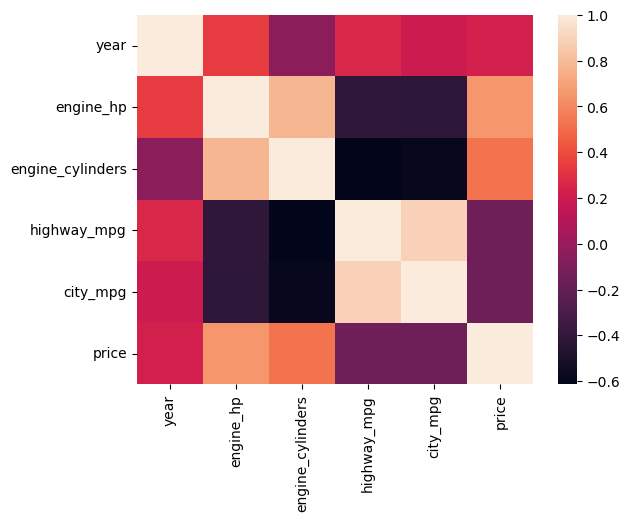

In [8]:
sns.heatmap(df.corr())

In [9]:
df['above_average'] = np.where(df.price > df.price.mean(), 1, 0)

In [10]:
y = df['above_average'].values
y_price = df['price'].values
y_price = np.log1p(y_price)
del df['above_average']
del df['price']

In [11]:
df_full_p, df_test_p, y_full_p, y_test_p = train_test_split(df, y_price, test_size=0.2, random_state=42)
df_train_p, df_val_p, y_train_p, y_val_p = train_test_split(df_full_p, y_full_p, test_size=0.25, random_state=42)

In [12]:
df_full, df_test, y_full, y_test = train_test_split(df, y, test_size=0.2, random_state=42)
df_train, df_val, y_train, y_val = train_test_split(df_full, y_full, test_size=0.25, random_state=42)

Question 3

In [13]:
categorical = list(df.dtypes[df.dtypes == 'object'].index)

In [14]:
numerical = [x for x in list(df.columns) if x not in categorical]

In [15]:
for i in categorical:
    mut_info = mutual_info_score(df_train[i], y_train)
    print(i, round(mut_info, 2))

make 0.24
model 0.46
transmission_type 0.02
vehicle_style 0.08


Question 4

In [16]:
train_dict = df_train.to_dict(orient='records')

In [17]:
dv = DictVectorizer(sparse=False)
dv.fit(train_dict)

DictVectorizer(sparse=False)

In [18]:
X_train = dv.transform(train_dict)

In [19]:
model = LogisticRegression(solver='liblinear', C=10, max_iter=1000, random_state=42)

In [20]:
model.fit(X_train, y_train)

LogisticRegression(C=10, max_iter=1000, random_state=42, solver='liblinear')

In [21]:
val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

In [22]:
model.predict_proba(X_val)

array([[9.99692966e-01, 3.07033780e-04],
       [2.27974745e-03, 9.97720253e-01],
       [9.99930206e-01, 6.97938861e-05],
       ...,
       [9.99898957e-01, 1.01043039e-04],
       [8.98629570e-03, 9.91013704e-01],
       [9.08719100e-03, 9.90912809e-01]])

In [23]:
y_pred = model.predict_proba(X_val)[:, 1]

In [24]:
y_pred

array([3.07033780e-04, 9.97720253e-01, 6.97938861e-05, ...,
       1.01043039e-04, 9.91013704e-01, 9.90912809e-01])

In [25]:
price = y_pred > 0.5

In [26]:
accuracy = (y_val == price).mean()

In [27]:
accuracy

0.946286193873269

Question 5

In [28]:
difference = {}

for column in list(df.columns):
    df_train_drop = df_train.copy()
    df_train_drop.drop([column], axis=1, inplace=True)
    df_val_drop = df_val.copy()
    df_val_drop.drop([column], axis=1, inplace=True)
    
    train_dict_drop = df_train_drop.to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    dv.fit(train_dict_drop)
    X_train_drop = dv.transform(train_dict_drop)
    
    model_drop = LogisticRegression(solver='liblinear', C=10, max_iter=1000, random_state=42)
    model_drop.fit(X_train_drop, y_train)
    
    val_dict_drop = df_val_drop.to_dict(orient='records')
    X_val_drop = dv.transform(val_dict_drop)
    
    model_drop.predict_proba(X_val_drop)
    y_pred_drop = model_drop.predict_proba(X_val_drop)[:, 1]
    price_drop = y_pred_drop > 0.5
    round((y_val == price_drop).mean(), 2)
    difference[column] = abs(accuracy - (y_val == price_drop).mean())
    print(f'drop {column}, difference {accuracy - (y_val == price_drop).mean()}')

drop make, difference -0.002937473772555599
drop model, difference 0.022240872849349502
drop year, difference -0.0016785564414604215
drop engine_hp, difference 0.015946286193873282
drop engine_cylinders, difference -0.0008392782207301552
drop transmission_type, difference 0.0012589173310951773
drop vehicle_style, difference 0.003776751993285754
drop highway_mpg, difference 0.0020981955518254436
drop city_mpg, difference 0.0004196391103650221


In [29]:
min(difference)

'city_mpg'

Question 6

In [30]:
train_dict = df_train.to_dict(orient='records')

In [31]:
dv = DictVectorizer(sparse=True)
dv.fit(train_dict)

DictVectorizer()

In [32]:
X_train = dv.transform(train_dict)

In [33]:
val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

In [34]:
alpha = {}

for i in [0, 0.01, 0.1, 1, 10]:
    model = Ridge(solver='sag', random_state=42, alpha=i, max_iter=1000)
    model.fit(X_train, y_train_p)
     
    
    y_pred = model.predict(X_val)
    alpha[i] = round(mean_squared_error(y_val_p, y_pred),3)

In [35]:
max(alpha)

10

In [36]:
alpha

{0: 0.268, 0.01: 0.268, 0.1: 0.268, 1: 0.268, 10: 0.268}